In [1]:
# load necessary libraries
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

## Fungsi dasar PID

In [2]:
def PID(Kp=1, Ti=1, Td=1, t_initial=0, u_bar=0, control_type='pid'):
    """Basic PID controller

    args:
    - Kp (int or float) default: 1 = proportional gain
    - Ti (int or float) default: 1 = integral period
    - Td (int or float) default: 1 = derivative period
    - t_initial (int or float) default: 0 = initial time
    - u_bar (int or float) default: 0 = base line for control signal
    - control_type (str) default: 'pid' = choose control type, i.e. either 'p' (proportional only), 'pi' (proportional and integral), 'pd' (proportional and derivative), or 'pid' (full PID)

    yield:
    - u (float) = control signal

    generator send():
    - t, feedback, ref (list-like type) = time, feedback (output from model), and reference
    """
    if not(control_type == 'p' or control_type == 'pi' or control_type == 'pd' or control_type == 'pid'):
        raise ValueError("'control_type' arg only accepts either 'p', 'pi', 'pd', or 'pid'")

    # initialize stored data
    e_prev = 0
    t_prev = t_initial #-100
    I = 0

    # initial control
    u = u_bar

    while True:
        # yield MV, wait for new t, PV, SP
        t, feedback, ref = yield u

        # PID calculations
        e = ref - feedback
        de = e - e_prev
        dt = t - t_prev

        P = Kp*e
        I = I + e*dt
        D = de/dt

        if control_type == 'p':
            u = u_bar + P
        elif control_type == 'pi':
            u = u_bar + Kp*(e + (1/Ti)*I)
        elif control_type == 'pd':
            u = u_bar + Kp*(e + Td*D)
        else:
            u = u_bar + Kp*(e + (1/Ti)*I + Td*D)

        # update stored data for next iteration
        e_prev = e
        t_prev = t

## Fungsi Transfer Sistem

Pastikan sinyal kontrol (MV) dapat menjadi input fungsi

In [3]:
def car_dynamics(b, v_in, u, m, dt):
    """Vehicle dynamics model

    args:
    - b (int or float) = friction constant (Nm/s)
    - v_in (int or float) = input/initial speed (m/s)
    - u (int or float) = control signal (N)
    - m (int or float) = vehicle mass (kg)
    - dt (int or float) = difference of time (s)

    return:
    v_out (float) = output/final speed (m/s)
    """
    temp = (-b*v_in + u)/m
    v_out = temp*dt + v_in
    return v_out

## Nilai sembarang untuk awal sistem 

In [4]:
# define constants - arbitrary values
Kp = 500
Ti = 0.5
Td = 0.1
mass = 1000 #kg
frict = 50 #Nm/s

## Definisi objek fungsi PID

In [5]:
# declare PID controller
controller = PID(Kp=Kp, Ti=Ti, Td=Td)
controller.send(None) # initialize controller

0

## Nilai SP 

In [6]:
# set speed reference
ref = np.ones(shape=50) * 5

## Variabel-Variabel kalkulasi

In [7]:
# define useful array variables
feedback = np.zeros(shape=ref.shape)
times = np.arange(start=1, stop=len(ref), step=1)
u = np.zeros(shape=ref.shape)
error = np.zeros(shape=ref.shape)
t_prev = 0 # buffer to store previous time

## Proses PID

In [8]:
# loop through each time t
for t in tqdm(times):
    error[t] = ref[t-1] - feedback[t-1] # get error at time t
    u[t] = controller.send([t, feedback[t-1], ref[t-1]]) # calculate PID
    feedback[t] = car_dynamics(b=frict, v_in=feedback[t-1], u=u[t], m=mass, dt=t-t_prev) # calculate model output
    t_prev = t # store for next iteration

100%|███████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 56153.25it/s]


## Plotting

Text(0, 0.5, 'Speed (m/s)')

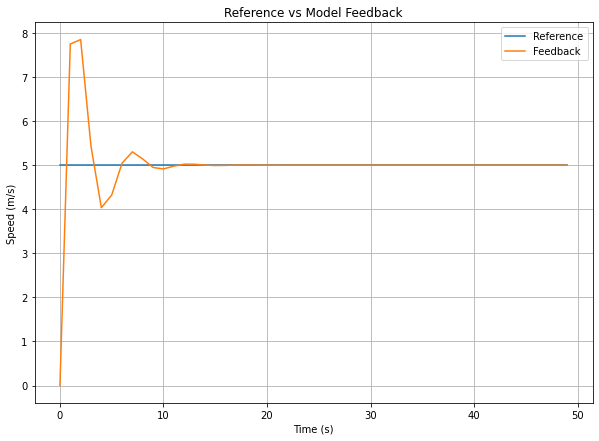

In [9]:
# plot reference vs feedback
plt.figure(figsize=(10,7))
line1, = plt.plot([0] + times.tolist(), ref)
line2, = plt.plot([0] + times.tolist(), feedback)
plt.legend([line1, line2], ['Reference', 'Feedback'])
plt.grid()
plt.title("Reference vs Model Feedback")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")

No handles with labels found to put in legend.


Text(0, 0.5, 'Force (N)')

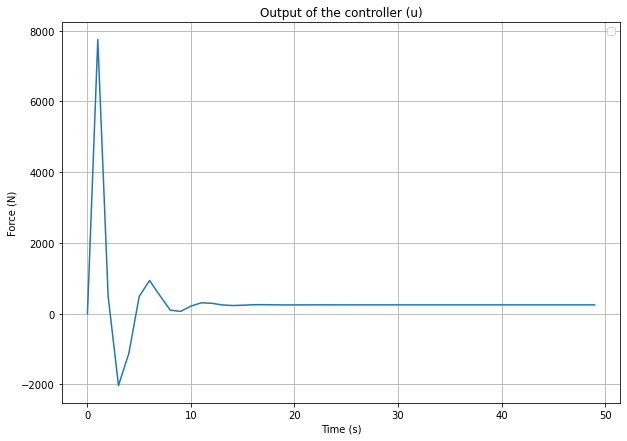

In [10]:
# plot u
plt.figure(figsize=(10,7))
plt.plot([0] + times.tolist(), u)
plt.legend()
plt.grid()
plt.title("Output of the controller (u)")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")

No handles with labels found to put in legend.


Text(0, 0.5, 'Error of speed (m/s)')

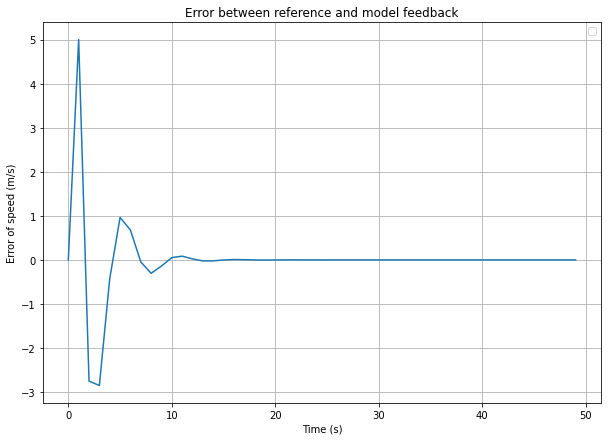

In [11]:
# plot error
plt.figure(figsize=(10,7))
plt.plot([0] + times.tolist(), error)
plt.legend()
plt.grid()
plt.title("Error between reference and model feedback")
plt.xlabel("Time (s)")
plt.ylabel("Error of speed (m/s)")